# EEG Data - Group Slope Analysis

Analyze Slope Data Across the Group (MIPDB Dataset)

In [1]:
%matplotlib inline

import os
import csv
import mne
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar, rcParams

In [2]:
# Import custom project related code
import sys
sys.path.append('/'.join(os.getcwd().split('/')[0:-1]))

# Import custom project related code
from core.utils import comb_corrs, bet_corrs
from core.db import EEGDB
from core.io import load_pickle

## Settings

In [3]:
SAVE_FIGS = False

## Setup

In [4]:
# Get project database object
db = EEGDB()

In [5]:
# Load data readme file
rmd_file = os.path.join(db.data_path, 'EEG', 'MIPDB_PublicFile.csv')
df = pd.read_csv(rmd_file, index_col='ID')

In [6]:
# Check distribution of sexes
print('Number of males: \t', sum(df.Sex == 1))
print('Number of females: \t', sum(df.Sex == 2))

Number of males: 	 69
Number of females: 	 57


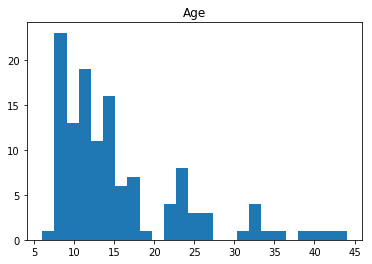

In [7]:
# Age distribution
df.hist('Age', grid=False, bins=25);

In [8]:
# Check the age range
print("Ages: {} - {}".format(min(df.Age), max(df.Age)))

Ages: 6 - 44


### Load subject data

In [9]:
# Check for saved FOOOF files
fres_files = db.check_fooof()

In [10]:
# Load all data into a list
all_dat = [load_pickle(f_name, db.fooof_path) for f_name in fres_files]

# Check number of subjects
n_subjs = len(all_dat)
print(n_subjs, ' subjects.')

98  subjects.


In [11]:
# Initialize dataframe to store slope data
sl_df = pd.DataFrame(columns=['ID', 'Age', 'Mean_Sl_EO', 'Median_Sl_EO', 'Mean_Sl_EC', 'Median_Sl_EC'])

# Collect data from all subjects
for dat in all_dat:
    
    sl_dat = {'ID': dat['ID'],
              'Age': df.loc[dat['ID']]['Age'],
              'Mean_Sl_EO': np.mean(dat['sls_eo_avg']),
              'Median_Sl_EO': np.median(dat['sls_eo_avg']),
              'Mean_Sl_EC': np.mean(dat['sls_ec_avg']),
              'Median_Sl_EC': np.median(dat['sls_ec_avg'])}
    
    sl_df = sl_df.append(sl_dat, ignore_index=True)

In [12]:
# Check out the dataframe
sl_df.head()

,ID,Age,Mean_Sl_EO,Median_Sl_EO,Mean_Sl_EC,Median_Sl_EC
0,A00051826,10.0,1.993436,1.993942,1.943103,1.934198
1,A00051886,12.0,1.961429,1.955402,2.031371,2.036248
2,A00051955,12.0,1.482905,1.480297,1.643428,1.658024
3,A00053375,6.0,1.788825,1.805748,1.830345,1.817368
4,A00053440,12.0,2.010997,2.047516,1.879631,1.927993


In [13]:
# Descriptive statistics
sl_df.describe()

,Age,Mean_Sl_EO,Median_Sl_EO,Mean_Sl_EC,Median_Sl_EC
count,98.000000,98.000000,98.000000,98.000000,98.000000
mean,15.459184,1.619074,1.627296,1.671736,1.675245
std,7.857190,0.336503,0.332027,0.332694,0.335790
min,6.000000,0.862034,0.819549,0.490674,0.455303
25%,10.000000,1.385970,1.386807,1.432952,1.441390
50%,13.000000,1.656187,1.670512,1.693712,1.692239
75%,17.750000,1.899327,1.892204,1.903880,1.912264
max,44.000000,2.268051,2.260224,2.383702,2.408580


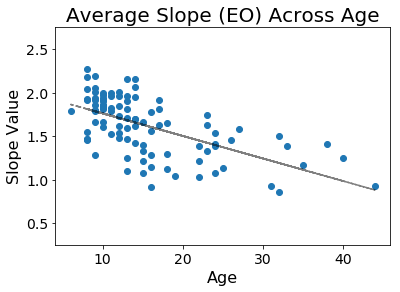

In [14]:
# Check EO Data Slope Vals
plt.figure()#figsize=[8, 6])
ax= plt.subplot(111)
ax.scatter(sl_df.Age, sl_df.Mean_Sl_EO)

plt.title('Average Slope (EO) Across Age', fontsize=20)
plt.ylim(0.25, 2.75);

plt.xlabel('Age', fontsize=16)
plt.ylabel('Slope Value', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14);

z = np.polyfit(sl_df.Age, sl_df.Mean_Sl_EO, deg=1)
plt.plot(sl_df.Age, z[0]*sl_df.Age + z[1], '--k', alpha=0.5);

# Save out figure
if SAVE_FIGS:
    plt.savefig('eo_age_scatter.png', format='png', bbox_inches='tight', dpi=300)

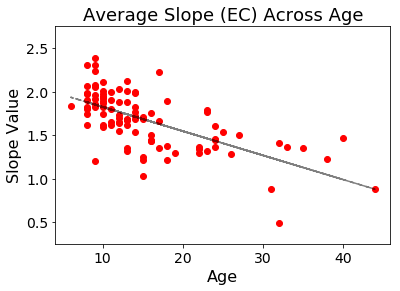

In [15]:
# Check EC Data Slope Vals
#plt.figure(figsize=[8, 6])

ax= plt.subplot(111)
ax.scatter(sl_df.Age, sl_df.Mean_Sl_EC, color='r')

plt.title('Average Slope (EC) Across Age', fontsize=18)
plt.ylim(0.25, 2.75);

plt.xlabel('Age', fontsize=16)
plt.ylabel('Slope Value', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14);

z = np.polyfit(sl_df.Age, sl_df.Mean_Sl_EC, deg=1)
plt.plot(sl_df.Age, z[0]*sl_df.Age + z[1], '--k', alpha=0.5);

# Save out figure
if SAVE_FIGS:
    plt.savefig('ec_age_scatter.png', format='png', bbox_inches='tight', dpi=300)

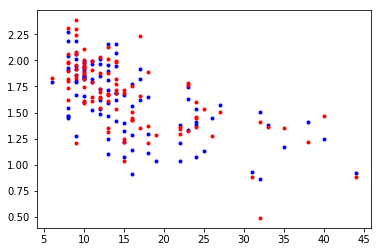

In [16]:
# Plot EC & EO Data Together
plt.figure()
plt.plot(sl_df.Age, sl_df.Mean_Sl_EO, 'b.');
plt.plot(sl_df.Age, sl_df.Mean_Sl_EC, 'r.');

In [17]:
# Check the correlation between slope & age (in both EO & EC conditions)
print(pearsonr(sl_df.Age, sl_df.Median_Sl_EO))
print(pearsonr(sl_df.Age, sl_df.Median_Sl_EC))

(-0.6112331603413076, 2.3174439113538775e-11)
(-0.6567158886887846, 2.0985351346445974e-13)


In [18]:
# Check correlation separately in 'kids' & 'adults'

# Kids
inds = sl_df.Age < 18
print('Kids Age & Slope correlation (n = {})'.format(sum(inds)))
print('\t', pearsonr(sl_df.Age[inds], sl_df.Mean_Sl_EC[inds]))

# Adults
inds = sl_df.Age > 18
print('Adults Age & Slope correlation (n = {})'.format(sum(inds)))
print('\t', pearsonr(sl_df.Age[inds], sl_df.Mean_Sl_EC[inds]))

Kids Age & Slope correlation (n = 73)
	 (-0.4758589526637051, 2.091201182982419e-05)
Adults Age & Slope correlation (n = 22)
	 (-0.43233704130970235, 0.0444853285336058)


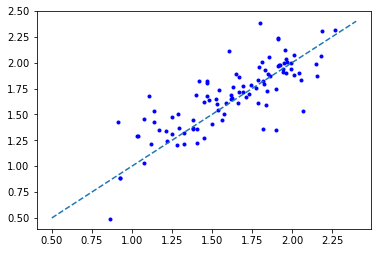

In [19]:
# Plot EC & EO Data Together
plt.figure()
plt.plot(sl_df.Mean_Sl_EO, sl_df.Mean_Sl_EC, 'b.')
line_dat = np.arange(0.5, 2.5, 0.1)
plt.plot(line_dat, line_dat, '--')

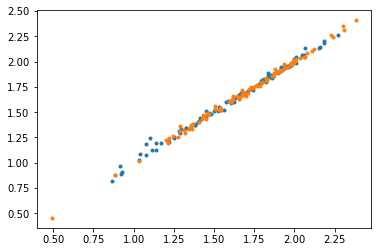

In [20]:
# Check mean vs. median
plt.plot(sl_df.Mean_Sl_EO, sl_df.Median_Sl_EO, '.')
plt.plot(sl_df.Mean_Sl_EC, sl_df.Median_Sl_EC, '.')

In [21]:
# Correlation between EC and EO data
print(pearsonr(sl_df.Median_Sl_EO, sl_df.Median_Sl_EC))

(0.8095133275231613, 6.246181656049965e-24)


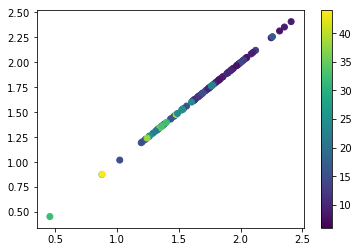

In [22]:
# Scatter with colormap mapping to z value
plt.scatter(sl_df.Median_Sl_EC, sl_df.Median_Sl_EC, c=sl_df.Age)
plt.colorbar()

### Group Topo Plots

In [23]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../data/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
n_chs = len(ch_labels)
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

# Create the info structure needed by MNE
info = mne.create_info(ch_labels, 500, 'eeg', montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(np.zeros([111, 1]), info, verbose=False)

In [24]:
# Create average slope values, averaged across all subjects

# Initialize arrays, and grab average slope results
sl_dat_eo = np.zeros(shape=[n_chs, n_subjs])
sl_dat_ec = np.zeros(shape=[n_chs, n_subjs])
for ind, dat in enumerate(all_dat):
    sl_dat_eo[:, ind] = dat['sls_eo_avg']
    sl_dat_ec[:, ind] = dat['sls_ec_avg']
    
# Average across subjects
sl_dat_eo_avg = sl_dat_eo.mean(axis=1)
sl_dat_ec_avg = sl_dat_ec.mean(axis=1)

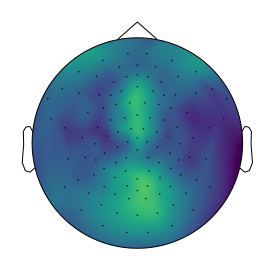

In [25]:
# Plot slope topography from average eyes-open data
fig, ax = plt.subplots()
mne.viz.plot_topomap(sl_dat_eo_avg, raw.info, vmin=1.5, vmax=1.8, cmap=cm.viridis, contours=0, axes=ax);
if SAVE_FIGS:
    fig.savefig('EO-Slope.png', dpi=600)

In [26]:
# Check range of data values
print('Min: ', sl_dat_eo_avg.min())
print('Max: ', sl_dat_eo_avg.max())

Min:  1.5418296748706097
Max:  1.7165460936771464


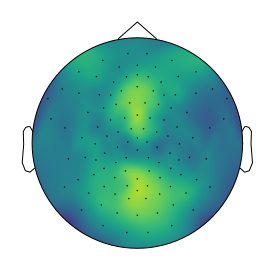

In [27]:
# Plot slope topography from average eyes-open data
fig, ax = plt.subplots()
mne.viz.plot_topomap(sl_dat_ec_avg, raw.info, vmin=1.5, vmax=1.8, cmap=cm.viridis, contours=0, axes=ax);
if SAVE_FIGS:
    fig.savefig('EO-Slope.png', dpi=600)

In [28]:
# Check range of data values
print('Min: ', sl_dat_ec_avg.min())
print('Max: ', sl_dat_ec_avg.max())

Min:  1.5919116035833802
Max:  1.7637707915155225


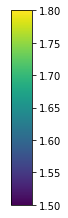

In [29]:
# Create a colorbar for the topography plots
fig = plt.figure(figsize=(2, 3))
ax1 = fig.add_axes([0.9, 0.25, 0.15, 0.9])

cmap = cm.viridis
norm = colors.Normalize(vmin=1.5, vmax=1.8)

cb1 = colorbar.ColorbarBase(plt.gca(), cmap=cmap,
                            norm=norm,
                            orientation='vertical')

if SAVE_FIGS:
    plt.savefig('colorbar.png', format='png', bbox_inches='tight', dpi=300)

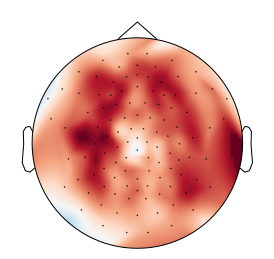

In [30]:
# Create a slope difference topography - between EC & EO
diff_sl = [sec - seo for sec, seo in zip(sl_dat_ec_avg, sl_dat_eo_avg)]
mne.viz.plot_topomap(diff_sl, raw.info, contours=0);

In [31]:
# Check the range of differences between EC & EO
print('EC/EO range of differences: {:0.4f} to {:0.4f}'.format(min(diff_sl), max(diff_sl)))

EC/EO range of differences: -0.0077 to 0.0978


In [32]:
# Check the correlation between EC and EO data
pearsonr(sl_dat_ec_avg, sl_dat_eo_avg)

(0.8825443237644707, 1.648685569956714e-37)

### Consistency Measures: Correlations Within & Between Epochs & State

In [33]:
# Calculate correlations within subjects, within and between states

corrs_eo = []
corrs_ec = []
corrs_bet = []

for dat in all_dat:
    
    corrs_eo.append(np.mean(comb_corrs(dat['sls_eo'])))
    corrs_ec.append(np.mean(comb_corrs(dat['sls_ec'])))
    corrs_bet.append(np.mean(bet_corrs(dat['sls_eo'], dat['sls_ec'])))

corrs_ec = [it for it in corrs_ec if not np.isnan(it)]

/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
# Calculate correlations between subjects, within and between states

corrs_diff_eo = []
corrs_diff_ec = []
corrs_diff_ec_eo = []

for ii, jj in zip(range(n_subjs-1), range(1, n_subjs)):
    corrs_diff_eo.append(np.mean(bet_corrs(all_dat[ii]['sls_ec'], all_dat[jj]['sls_ec'])))
    corrs_diff_ec.append(np.mean(bet_corrs(all_dat[ii]['sls_eo'], all_dat[jj]['sls_eo'])))
    corrs_diff_ec_eo.append(np.mean(bet_corrs(all_dat[ii]['sls_ec'], all_dat[jj]['sls_eo'])))

In [35]:
# Collect all correlations, and labels, together
all_corrs = [corrs_ec, corrs_eo, corrs_bet, corrs_diff_ec, corrs_diff_eo, corrs_diff_ec_eo]    
corr_labels = ['EC-Within', 'EO-Within', 'EC/EO-Within', 'EC-Between', 'EO-Between', 'EO/EC-Between']

In [36]:
# Check average correlation values within & between states & subjects
for corr, label in zip(all_corrs, corr_labels):
    print(label, '\t{:0.4f}'.format(np.mean(corr)))

EC-Within 	0.5260
EO-Within 	0.3977
EC/EO-Within 	0.3807
EC-Between 	0.0517
EO-Between 	0.0712
EO/EC-Between 	0.0552


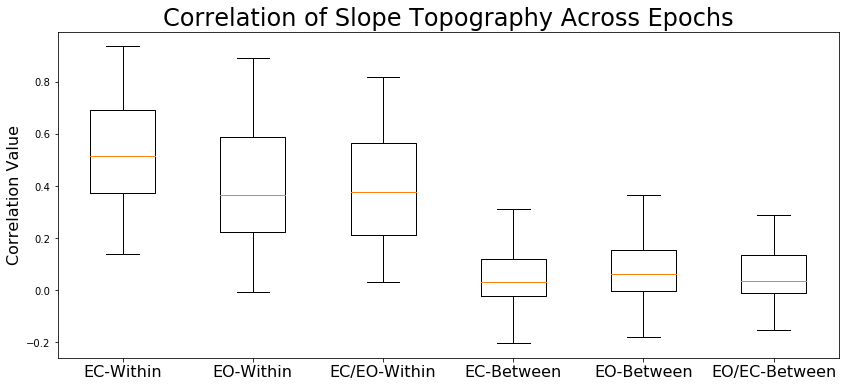

In [37]:
# Plot the correlations across epochs
fig, ax = plt.subplots(figsize=(14, 6))
plt.boxplot(all_corrs);

plt.title('Correlation of Slope Topography Across Epochs', fontsize=24);
plt.ylabel('Correlation Value', fontsize=16);

xtickNames = plt.setp(ax, xticklabels=corr_labels)
plt.setp(xtickNames, fontsize=16);

# Save out figure
if SAVE_FIGS:
    plt.savefig('topo_corr_boxplot.png', format='png', bbox_inches='tight', dpi=300)

In [38]:
# Check the spatial correlation
ind = 2
print(pearsonr(sl_dat_ec_avg, montage.pos[:, ind]))
print(pearsonr(sl_dat_eo_avg, montage.pos[:, ind]))

(0.34905021446372786, 0.00017358475389298258)
(0.26706357493098143, 0.004604218049812867)


In [39]:
# Collapse to 2D topography
pos_2d = montage.get_pos2d()

In [40]:
# Check the spatial correlation
ind = 1
print(pearsonr(sl_dat_ec_avg, pos_2d[:, ind]))
print(pearsonr(sl_dat_eo_avg, pos_2d[:, ind]))

(-0.22088339388747677, 0.019824108340786503)
(-0.3080283151255997, 0.0010058196864047794)


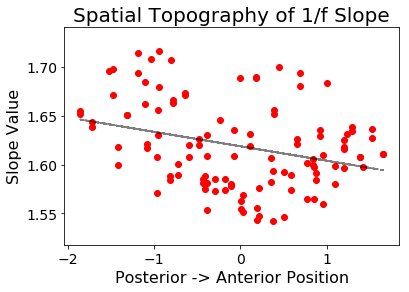

In [41]:
# Plot scatter matrix of slopes vs. postitions
ind = 1
#plt.figure(figsize=[8, 6])
plt.scatter(pos_2d[:, ind], sl_dat_eo_avg, color='r');

plt.title('Spatial Topography of 1/f Slope', fontsize=20);
plt.xlabel('Posterior -> Anterior Position', fontsize=16);
plt.ylabel('Slope Value', fontsize=16);

plt.tick_params(axis='both', which='major', labelsize=14);

z = np.polyfit(pos_2d[:, ind], sl_dat_eo_avg, deg=1)
plt.plot(pos_2d[:, ind], z[0]*pos_2d[:, ind] + z[1], '--k', alpha=0.5);

# Save out figure
if SAVE_FIGS:
    plt.savefig('ant_pos_corr.png', format='png', bbox_inches='tight', dpi=300)

In [42]:
# Check the spatial correlation
ind = 0
print(pearsonr(sl_dat_ec_avg, abs(pos_2d[:, ind])))
print(pearsonr(sl_dat_eo_avg, abs(pos_2d[:, ind])))

(-0.6774949614899473, 3.2070335179735957e-16)
(-0.6584533392399201, 4.0326314078357656e-15)


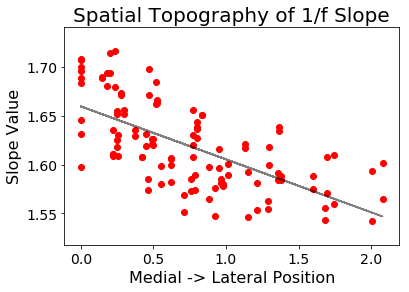

In [43]:
# Plot scatter matrix of slopes vs. postitions
ind = 0
#plt.figure(figsize=[8, 6])
plt.scatter(abs(pos_2d[:, ind]), sl_dat_eo_avg, color='r');

plt.title('Spatial Topography of 1/f Slope', fontsize=20);
plt.xlabel('Medial -> Lateral Position', fontsize=16);
plt.ylabel('Slope Value', fontsize=16);

plt.tick_params(axis='both', which='major', labelsize=14);

z = np.polyfit(abs(pos_2d[:, ind]), sl_dat_eo_avg, deg=1)
plt.plot(abs(pos_2d[:, ind]), z[0]*abs(pos_2d[:, ind]) + z[1], '--k', alpha=0.5);

# Save out figure
if SAVE_FIGS:
    plt.savefig('med_lat_corr.png', format='png', bbox_inches='tight', dpi=300)